In [1]:
#Created on Wed Aug  30 14:27:32 2023
#@author: fkuhn
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
!pip install mpld3
import mpld3 #install conda-forge
#mpld3.enable_notebook() # allows zooming in plots
!pip install --upgrade matplotlib
from matplotlib import gridspec as gridspec
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 300
import math
import scipy
from scipy.optimize import curve_fit
%matplotlib inline
from scipy import signal as sig
from shapely.geometry import Polygon #install conda-forge
!pip install uncertainties
import uncertainties as unc #install pip
import uncertainties.unumpy as unp
import sys
sys.path.append("../../src/W0D6_2P_Analysis")
import pandas as pd
from tqdm import tqdm
from scipy.signal import savgol_filter


from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 692.9 kB/s eta 0:00:00
Mounted at /content/drive



#Import sample file:



In [2]:
filepath = '/content/drive/MyDrive/LINdoscope2023_analysis/sample_data/2P_dCA1_treadmill/calcium_behaviour.h5'

behaviour_calcium = pd.read_hdf(filepath)
calcium = np.load('/content/drive/MyDrive/calcium_signal_S.npy')




In [3]:
cell_num = len(behaviour_calcium['cell'].keys())
print('number of cells = ' + str(cell_num))

number of cells = 977


#List all the behavioural recordings available in the dataframe


In [4]:
print(behaviour_calcium['behaviour'].keys())

Index(['NIframes', 'camframes', 'Time_s', 'Lap', 'Position', 'Velocity_ds',
       'Velocity_Kalman', 'Pump', 'Licking', 'PupilDiam', 'PupilX', 'PupilY',
       'EyeLidDist', 'EyeBlinks', 'MotionEnergy_Nose',
       'MotionEnergy_Whiskerpad', 'MotionEnergy_Mouth', 'MotionEnergy_Cheek',
       'OFmag_Nose', 'OFmag_Whiskerpad', 'OFmag_Mouth', 'OFmag_Cheek',
       'OFang_Nose', 'OFang_Whiskerpad', 'OFang_Mouth', 'OFang_Cheek',
       'Whisking_freq', 'Sniff_freq', 'Chewing_Envelope', 'Chew',
       'PointMotion_FrontPaw', 'PointMotion_Mouth', 'Angle_Tail_3',
       'Angle_Tail', 'Angle_Paws_Front_3', 'Angle_Paws_Front',
       'Angle_Paws_Back', 'Angle_Paws_Back_3', 'Height_Bum'],
      dtype='object')


# The behavioural paradigm:

A mouse runs on a linear treadmill treadmill with 360 cm in length. The treadmill is divided into 6 60 cm long zones with different tactile and visual cues. The mouse has learned to receive a water reward between 330cm and 360cm upon licking on a small pipe. The paradigm is illustrated in panel A of the attached figure.

 Since we are interested in the spatial information that is contained by the neurons' activity in this tutorial, let's assume that for now we only have access to the position across time (mouse's position between 0 and 360) synchronized with a deconvolved calcium signal that is already synced to the position recording.

![Example Image](https://www.biorxiv.org/content/biorxiv/early/2023/03/09/2023.03.09.531869/F1.large.jpg)



Lets load the behavioural data and extract position and time information only for now.

In [555]:
time = behaviour_calcium['behaviour']['Time_s']
position = behaviour_calcium['behaviour']['Position']
lap = behaviour_calcium['behaviour']['Lap'] -38 # couting of example dataset starts with 38



Text(0.5, 1.0, 'Position')

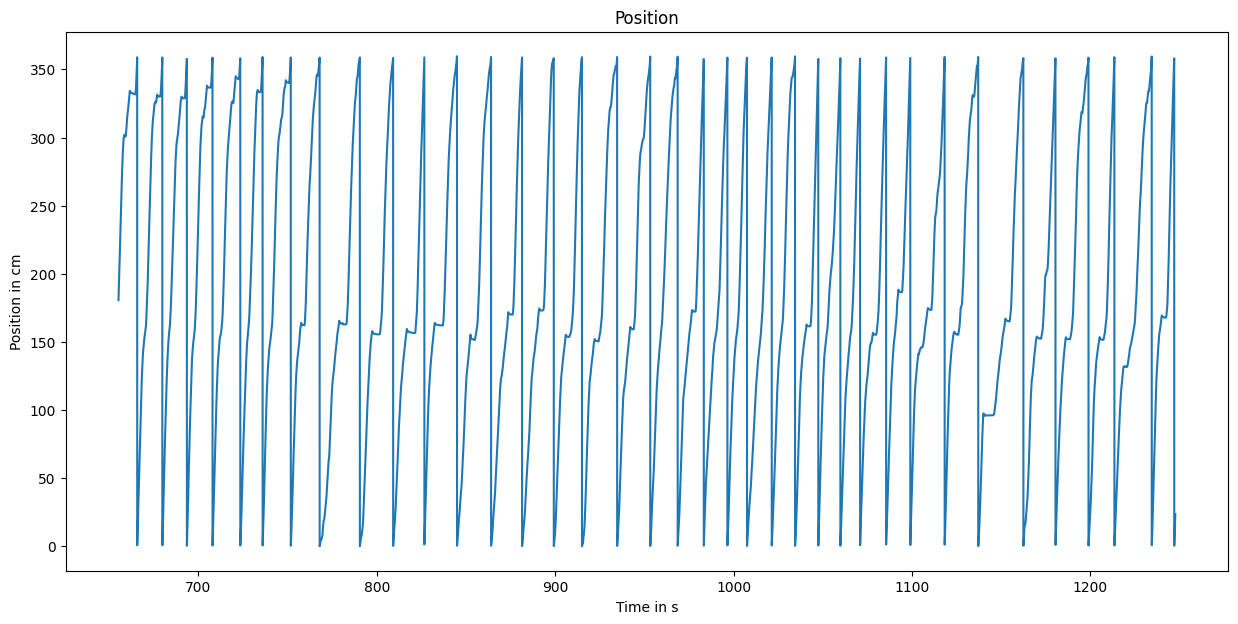

In [556]:
%matplotlib inline
# plot position
plt.figure(figsize=(15,7))
plt.plot(time,position,label='Position in cm')
plt.xlabel('Time in s')
plt.ylabel('Position in cm')
plt.title('Position')



#Let's infer the velocity of the animal from position and time information by  using a Kalman filter

The Kalman filter is a mathematical technique used to estimate the speed of an object, like a mouse, based on its position measurements over time. It works by predicting where the object should be at a certain time based on its previous movements, and then comparing that prediction with the actual position measurement taken. It uses this comparison to update its estimate of the animal's speed, making it a more accurate and refined estimation with each new measurement. The Kalman filter takes into account both the object's expected behavior and the uncertainty in measurements to provide a reliable speed estimate.

![Example Image](https://www.researchgate.net/publication/354627620/figure/fig4/AS:1080241044889618@1634560943438/Working-principle-of-Kalman-filter.jpg)

For the calculation we first have to transform position into distance such that there will be no artifacts when the position jumps from 360 cm to 0 cm.


Text(0.5, 1.0, 'Distance traveled over time')

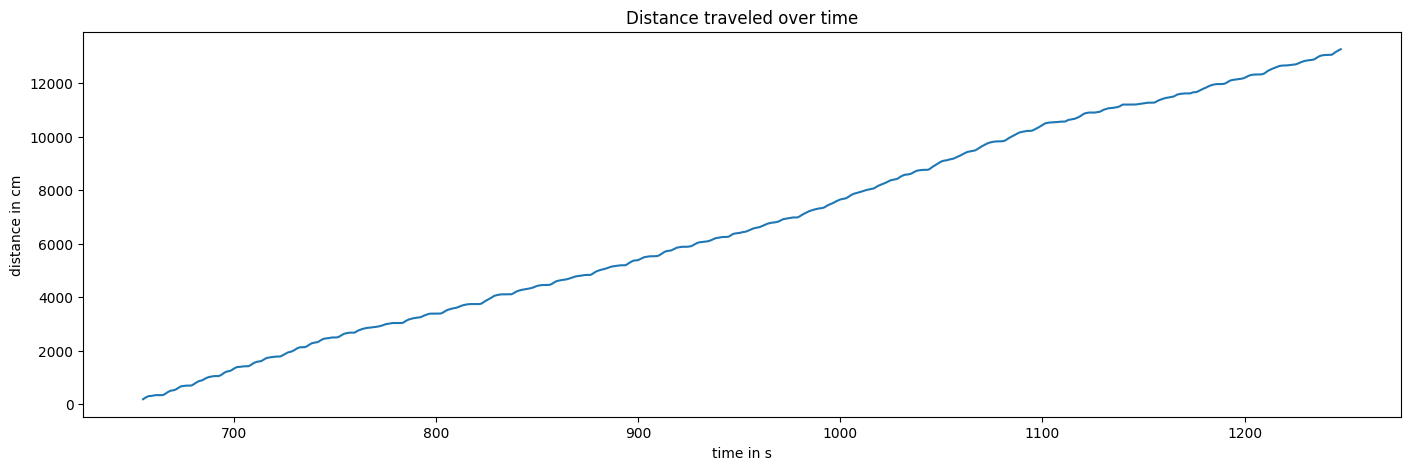

In [557]:
distance = np.unwrap(position)
measurements = distance

plt.figure(figsize = (17,5))
plt.plot(time,distance)
plt.xlabel('time in s')
plt.ylabel('distance in cm')
plt.title('Distance traveled over time')


In [558]:
#calculate mean timesteps of measurement:
dt = np.mean(np.diff(time))

# Initialize mean of state variable x.
# First row is initial position and second row is initial velocity.
#    x  x'


x = np.array([[distance[0]], [0]], ndmin=2)  # Initial State (Location and velocity)
P = np.array([[1, 0], [0, 100]])  # Initial Uncertainty
A = np.array([[1, dt], [0, 1]])  # Transition Matrix

# Measurement function
H = np.array([1, 0], ndmin=2)

# measurement noise covariance; 1e-3 recommended, smaller values for precise onset, larger for smooth velocity
R = 1e-2

# Process Noise Covariance
Q = np.array([[1 / 4 * dt ** 4, 1 / 2 * dt ** 3], [1 / 2 * dt ** 3, dt ** 2]])

# Identity matrix
I = np.identity(2)

#  compare to datapoints
posF = []
vF = []

# Display a bar to show progress
with tqdm(total=len(distance)) as pbar:
    for n, measurement in enumerate(measurements):
        # Prediction
        x = np.matmul(A, x)  # predicted State
        P = A @ P @ A.transpose() + Q  # predicted Covariance

        # Correction
        Z = measurement
        y = Z - np.matmul(H, x)  # Innovation from prediction and measurement
        S = H @ P @ H.transpose() + R  # Innovation-covariance
        K = np.matmul(P, H.transpose()) / S  # Filter-Matrix (Kalman-Gain)

        x = x + (K * y)  # recalculation of system state
        # print(x)
        posF.append(np.float64(x[0]))
        vF.append(np.float64(x[1]))

        P = np.matmul(I - (np.matmul(K, H)), P)  # recalculation of covariance
        pbar.update(1)

    velocity = np.array(vF)

100%|██████████| 18000/18000 [00:00<00:00, 22494.83it/s]


# Let's plot position and velocity for a lap of your choice.

Text(0.5, 1.0, 'Position and Velocity of Lap 9')

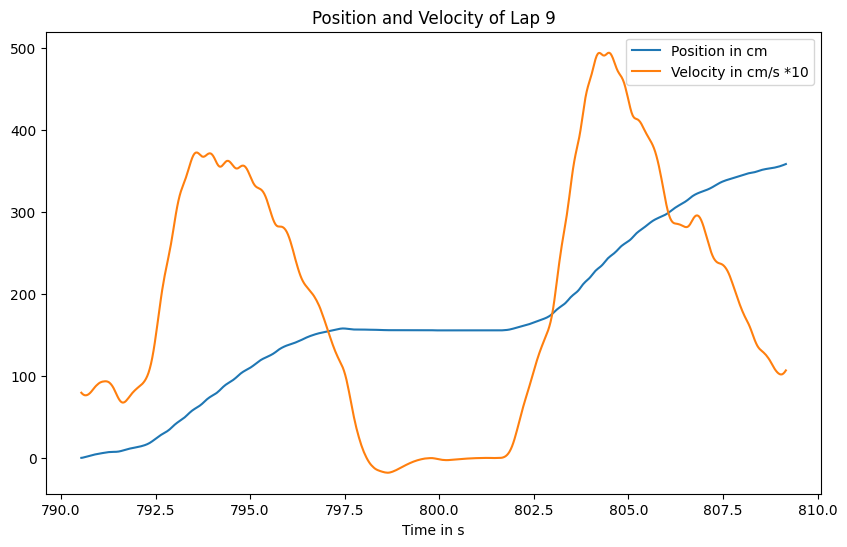

In [559]:
%matplotlib inline
lap_oi = 9 #adjust here

position_lap_oi = position[lap==lap_oi]
velocity_lap_oi = velocity[lap==lap_oi]
time_lap_oi = time[lap==lap_oi]

plt.figure(figsize=(10,6))
plt.plot(time_lap_oi,position_lap_oi,label='Position in cm')
plt.plot(time_lap_oi,velocity_lap_oi*10,label='Velocity in cm/s *10')
plt.xlabel('Time in s')
plt.legend(loc='upper right')
plt.title('Position and Velocity of Lap ' + str(lap_oi))


# Now let's load the neural data and explore the deconvolved calcium signal of some cells!

In this tutorial we will use the deconvolved event traces that were calculated with CNMF to avoid differential effects of
GCaMP6s calcium signal tails at different animal velocities
across space.


NameError: ignored

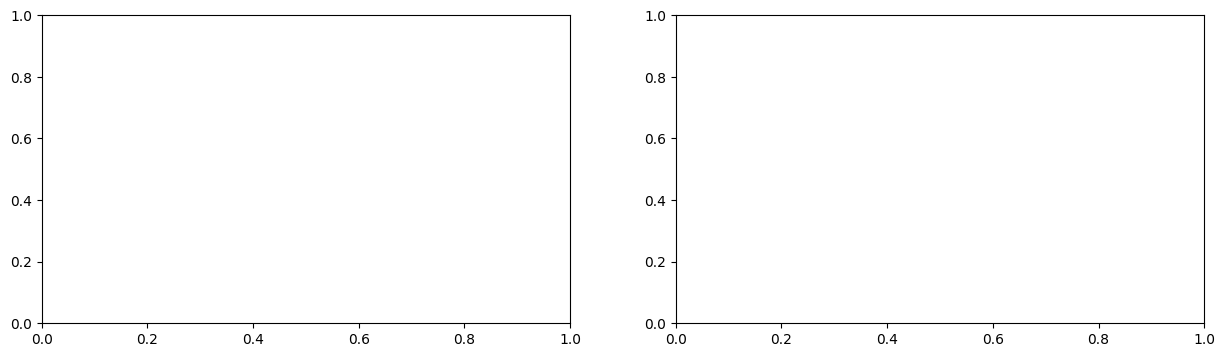

In [5]:

# plot calcium signal of single cell
#calcium_signal = behaviour_calcium['cell']
column_names = list(range(977))  # Column names 0, 1, 2, 3, ...
calcium_signal = pd.DataFrame(calcium.T, columns=column_names)


cell_oi = 934

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].plot(time,calcium_signal[cell_oi])
ax[0].set_xlabel('time in s')
ax[0].set_ylabel('deconvolved calcium signal')

# zoom in plot
ax[1].plot(time[:200],calcium_signal[cell_oi][:200]) # Adjust to where you want to zoom
ax[1].set_xlabel('time in s')
ax[1].set_ylabel('deconvolved calcium signal')


# Let's find some place cells !

There are multiple definitions about when to call a placecell a placecell and in the end it is a matter of definition. However, there are multiple ways how to quantify place information of cells which can be useful in terms of a quantitative analysis.

At first let's calculate the mean signal of position bins across the treadmill belt for each lap, as well as the mean occupancy which we need for the calculation of spatial information (see next cell). Note that for place cell discovery we will only use signal where the animal is actualy moving, i.e. where its velocity is above velocity threshold v_thresh.

In [592]:
binwidth = 12 # cm
beltlength = 360 # cm
numBins = beltlength/binwidth
v_thresh = 2 # cm/s
Bin_edges = np.arange(0,beltlength,binwidth) # boarders of position bins


# Include behavioural data in the dataframe to makes things comfortable:

calcium_signal.loc[:,'Position'] = position
calcium_signal.loc[:,'Velocity'] = velocity
calcium_signal.loc[:,'Lap'] = lap
calcium_signal_run = calcium_signal[velocity>v_thresh]
calcium_signal_run = calcium_signal_run[lap>min(lap)+2] # exclude last and first lap, since not whole belt covered there
calcium_signal_run = calcium_signal_run[lap <max(lap)]
calcium_signal_run.loc[:,'Bin'] = np.digitize(calcium_signal_run.Position,Bin_edges)-1 # to make it start at0
calcium_signal_run = calcium_signal_run.reset_index(drop=True)



# loop through each cell to calculate binned signal
# bin signal using pandas 'pivot' function.
# Also count the datapoints per in and multiply with dt in order to obtain
# occupancy per bin

def bin_signal(signal):

    binned_signal = signal.groupby('Bin').mean()[:cell_num]

    mean_signal = signal.mean()[:cell_num]

    occupancy = signal.groupby('Bin').count()[0]

    occupancy_prob = occupancy/np.sum(occupancy)

    return binned_signal, occupancy, occupancy_prob, mean_signal


binned_signal, occupancy, occupancy_prob, mean_signal = bin_signal(calcium_signal_run)



# Let us first calculate the spatial information score for each cell:

Spatial information is defined as $$
SI = \sum_{i} o_{i} \cdot \frac{a_{i}}{\overline{a}} \cdot \log_{2} \left( \frac{a_{i}}{\overline{a}} \right)
$$ where i denotes the i-th spatial bin, oi is the animal’s relative occupancy of spatial bin i, ai is the mean calcium activity at spatial bin i, and a¯ is the overall mean calcium activity of the respective cell. Note that SI is a conservative measure and usable for scenarios where we expect mainly one placefield per place cell. Some hippocampal cells with several clear place fields for example may have less spatial information overall althogh they are  spatially tuned.

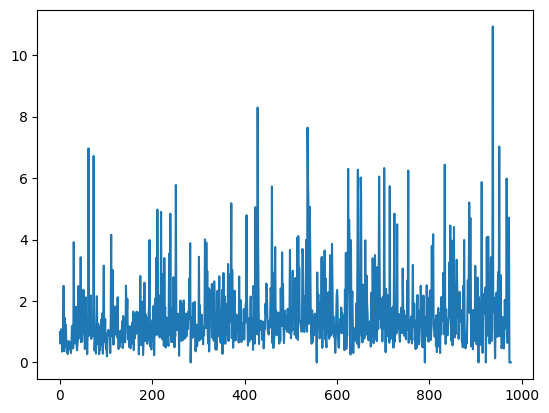

In [562]:
def calculate_placescore(binned_signal,occupancy_prob,mean_signal):
  score = (occupancy_prob * (binned_signal/ binned_signal.mean()).T) * np.real(
        np.log2((binned_signal / binned_signal.mean()))).T

  placescore = score.sum(axis=1)

  return placescore

placescore = calculate_placescore(binned_signal,occupancy_prob,mean_signal)


def calculate_placescore1(binned_signal,occupancy_prob,mean_signal):
  score = (occupancy_prob * (binned_signal/mean_signal).T) * np.real(
        np.log2((binned_signal / mean_signal))).T

  placescore1 = score.sum(axis=1)

  return placescore1

placescore1 = calculate_placescore1(binned_signal,occupancy_prob,mean_signal)


# Criterion 1: Place score percentile

In order to call a place cell as a place cell, one criterion is place score percentile. It is calculated by shuffling the signal of the cells N times (typically N= 1000 - here, due to computation time reasons N = 100) on the time axis. Then we calculate the placescore for each shuffled signal, to see how likely it is that we obtained a high placescore just by chance. When place score value of the actual signal is far out from distribution mean, i.e. percentile > 0.95, the place score is likely not just that high "by chance".

In [563]:
TableToShift = calcium_signal_run
NumBlocks = max(lap)
blocklen = int(len(calcium_signal_run)/NumBlocks)
iters = 100

def shuffle_blocks(column, blocklen):
      values = column.values
      num_blocks = len(column) // blocklen
      remaining_values = len(column) % blocklen

      # Shuffle complete blocks
      if num_blocks > 0:
          blocks = values[:num_blocks * blocklen].reshape(num_blocks, blocklen)
          np.random.shuffle(blocks)
          values[:num_blocks * blocklen] = blocks.ravel()

      # Shuffle any remaining values
      if remaining_values > 0:
          remaining = values[num_blocks * blocklen:]
          np.random.shuffle(remaining)
          values[num_blocks * blocklen:] = remaining

      return pd.Series(values)


placescore_shuffled = {}
for i in tqdm(range(0,iters), desc="Iterating across shuffles"):
  # 1: Circular Shifting with > 500 Frames:
  IndexShift = int(np.random.uniform(low=500, high=(len(calcium_signal_run.index) - 500), size=1))
  ShiftTable = TableToShift.reindex(index=np.roll(TableToShift.index, IndexShift)).reset_index(drop=True)

  # Apply the shuffle_blocks function to all column
  ShuffledTable = ShiftTable.apply(shuffle_blocks, args=(blocklen,), axis=0)

  #ShuffledTable.reset_index(drop=True, inplace=True)
  calcium_signal_run1 = calcium_signal_run.copy()
  calcium_signal_run1.reset_index(drop=True, inplace=True)

  ShuffledTable = ShuffledTable.drop('Bin',axis=1)
  ShuffledTable['Bin'] = calcium_signal_run1['Bin']
  # Calculate binned signal for shuffled dataframe
  binned_signal1, occupancy1, occupancy_prob1, mean_signal1 = bin_signal(ShiftTable)

  # Calculate place score
  placescore_shuffled[i] = calculate_placescore1(binned_signal1,occupancy_prob1,mean_signal1)

Iterating across shuffles: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Let's find the cell indices with a percentile higher than 95:

In [564]:
placescore = placescore1[:976]
threshold= 95 # the placescore of the original signal should be higher than
# 95 percent of shuffled ones

percentiles = {}
for i in range(0,cell_num):
    values_at_position = [placescore_shuffled[arr_name][i] for arr_name in placescore_shuffled]
    percentile_90 = np.percentile(values_at_position, threshold)
    percentiles[i] = percentile_90

# Compare values in placescore with the calculated percentiles to identify higher values
indices_placecells = [i for i, test_value in enumerate(placescore) if test_value > percentiles[i]]

# Print the indices where values in placescore are higher
print("Indices where placescore values are higher than", str(threshold), "th percentile:")
print(indices_placecells)



Indices where placescore values are higher than 95 th percentile:
[1, 3, 4, 6, 8, 10, 22, 24, 25, 31, 35, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 58, 64, 65, 68, 72, 74, 78, 79, 80, 82, 83, 86, 88, 91, 94, 95, 100, 102, 104, 105, 106, 108, 110, 115, 116, 117, 118, 121, 122, 127, 129, 130, 140, 142, 148, 150, 155, 157, 159, 160, 162, 163, 168, 171, 175, 177, 188, 189, 190, 194, 199, 203, 205, 211, 217, 219, 224, 227, 229, 230, 233, 235, 236, 240, 246, 248, 257, 259, 262, 265, 270, 278, 282, 285, 287, 291, 294, 297, 299, 300, 302, 308, 310, 311, 315, 318, 325, 326, 327, 331, 339, 342, 344, 352, 358, 359, 363, 367, 369, 375, 377, 378, 380, 384, 386, 388, 391, 394, 396, 398, 401, 407, 411, 414, 415, 419, 421, 424, 428, 433, 436, 437, 440, 442, 444, 447, 449, 452, 454, 457, 458, 462, 469, 475, 479, 480, 481, 485, 487, 493, 509, 514, 516, 525, 528, 530, 531, 532, 533, 543, 545, 547, 548, 557, 559, 561, 568, 570, 573, 575, 580, 583, 587, 590, 592, 593, 602, 605, 618, 619, 624, 626, 633, 637, 

#Let's check out some cells with high percentile!
 When exploring a bit you can see that place cells have a relatively few relativlely high peaks, but do not fire very reliably across laps. Thus, let's add some reliability criterion!



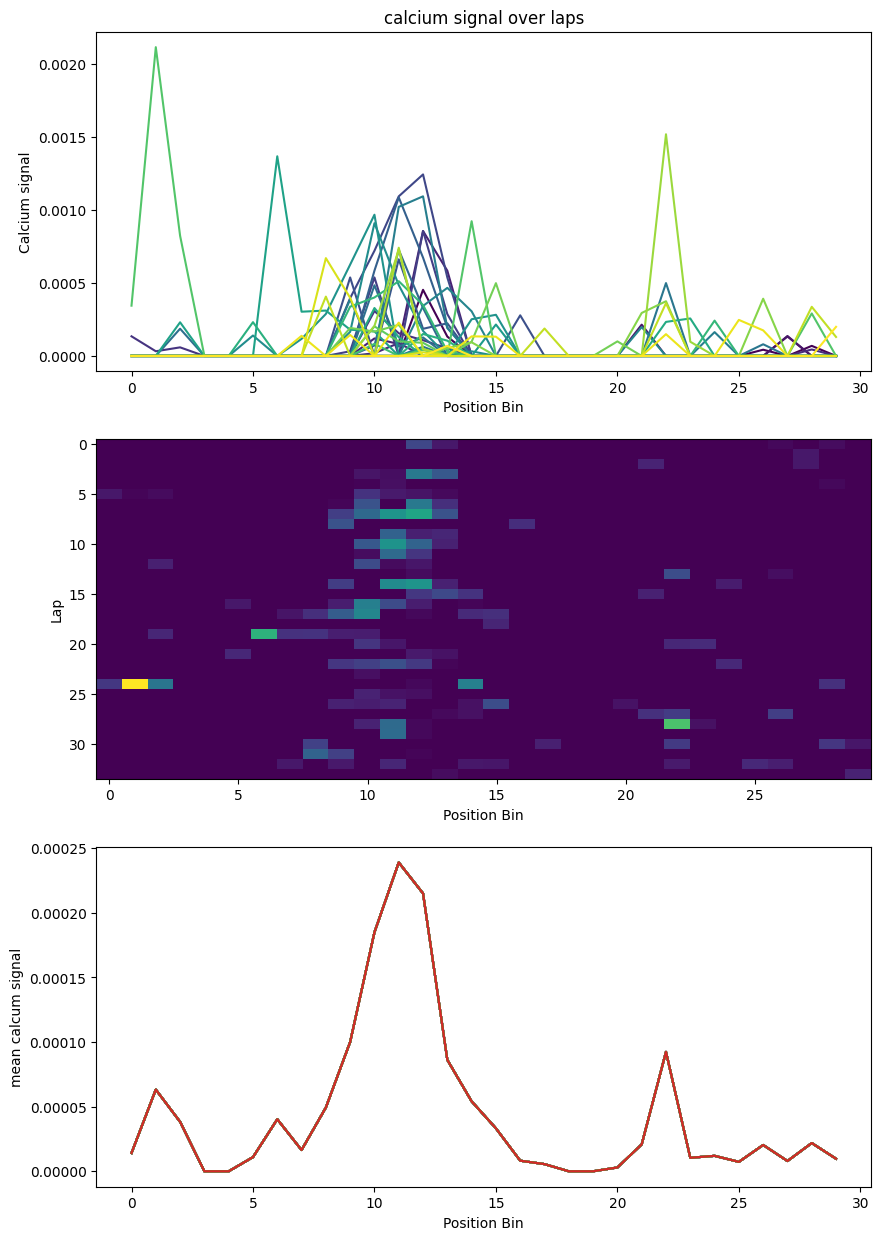

In [663]:
cell_oi = 35 # adjust cell index to display cell of your interest

calcium_signal_run_celloi = calcium_signal_run[[cell_oi,'Lap','Bin']]
calcium_signal_laps = calcium_signal_run_celloi.pivot_table(index='Lap', columns='Bin', values=cell_oi, aggfunc='mean')

# Apply smoothing to inferred calcium signal:



cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(3,figsize = (10,15))
for i in range(np.shape(calcium_signal_laps)[0]):
    color = cmap(i / (np.shape(calcium_signal_laps)[0] - 1))
    ax[0].plot(np.array(calcium_signal_laps)[ i,:], color=color, label=f'Row {i}')
    ax[0].set_xlabel('Position Bin')
    ax[0].set_ylabel('Calcium signal')
    ax[0].set_title('calcium signal over laps')

    ax[1].imshow(calcium_signal_laps,cmap='viridis',aspect='auto')
    ax[1].set_xlabel('Position Bin')
    ax[1].set_ylabel('Lap')

    ax[2].plot(np.mean(calcium_signal_laps,axis=0))
    ax[2].set_xlabel('Position Bin')
    ax[2].set_ylabel('mean calcum signal')


# Let's calculate the place cells' placefield and reliability

Place fields are obtained
by replicating the binned_signal trace by a factor of 3 to account for circularity of the belt. Then we apply a Savitzky-Golay filter to account for skewed place field activity (here we use window_length of 8. Note that the bigger the window_length, the 'smoother' the signal).

The resulting filtered spatial calcium activity is then searched for peaks using Scipy’s find_peaks function (width: 1 frame;
prominence: 1.5 standard deviations; relative height: 0.8),

The most prominent peak is used as primary place field and
left/right interpolated intersection points as place field beginning/end. All these values are given to us from scipy's find_peaks function.

However, note also that there might be plasticity effects of PCs changing their place fields to another location or developing a place field later! In order to account for this, one could use sliding windows and calculate the stability in the sliding windows - However, for now let's assume place fields should be relatively stable across laps, since the animal is not learning a spatial representation any more during the recording, but has learned it before already.**bold text**

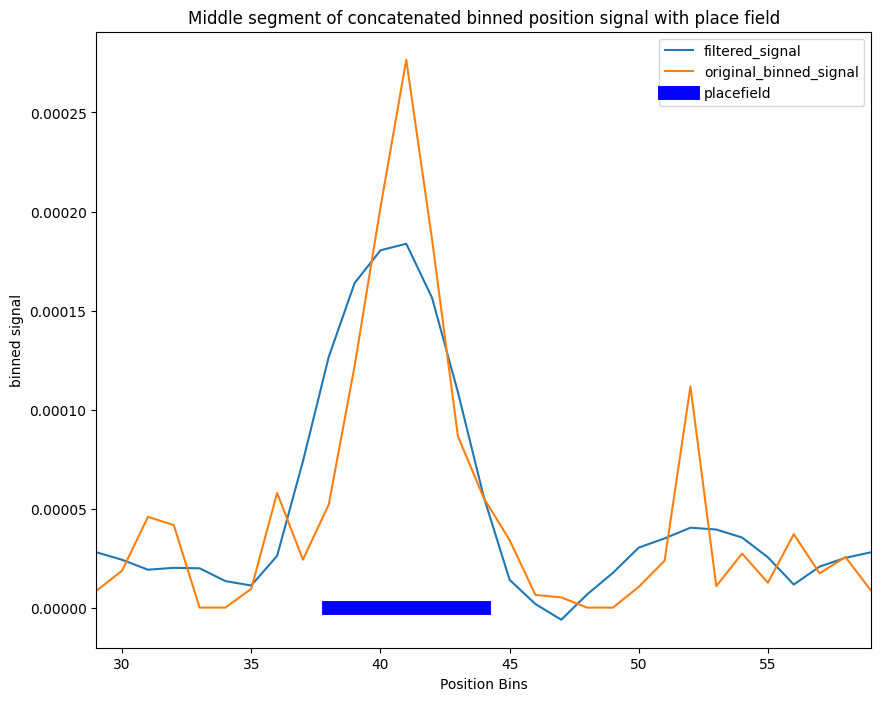

In [580]:
cell_oi = 35

def calculate_placefields(cell_oi):
  binned_signal_concatenated = np.array([[binned_signal[cell_oi]]*3]).flatten()
  filtered_signal = savgol_filter(binned_signal_concatenated,window_length=int(numBins/3),polyorder=2)
  filtered_signal_normalized = filtered_signal /np.max(filtered_signal)


  peak_info = sig.find_peaks(filtered_signal_normalized,\
                                  width = numBins/20,\
                                  height = 0.7, distance = (numBins/20))

  if len(peak_info[0])>0:
    peak_heights = peak_info[1]['peak_heights']
    PF_peak_locations = peak_info[0]
    PF_peak_height = np.max(peak_heights)
    PF_idx = np.where((peak_heights==PF_peak_height))
    PF_peak_width = peak_info[1]['widths']

    PF_left_edge = np.ceil(peak_info[1]['left_ips'])
    PF_right_edge = np.ceil(peak_info[1]['right_ips'])
  else:
    PF_left_edge = []
    PF_right_edge = []

  return peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge


# Let's plot binned mean signal, filtered signal and place fields for cell_oi!
# If no placefield is displayed it's because the cell of interest doesn't have one following the criteria shown above

peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge = calculate_placefields(cell_oi)

fig, ax = plt.subplots(figsize=(10, 8))
line1, = ax.plot(filtered_signal)
line2, = ax.plot(binned_signal_concatenated)

if len(peak_info[0])>0:
  for x in range(len(PF_right_edge)):
        line3, = ax.plot([PF_left_edge[x], PF_right_edge[x]], [0, 0], color='blue', linewidth=10)

ax.set_xlim([numBins-1,numBins*2-1])  # Adjust the x-axis limits as needed
ax.legend([line1, line2, line3], ['filtered_signal', 'original_binned_signal', 'placefield'])
ax.set_ylabel('binned signal')
ax.set_xlabel('Position Bins')
ax.set_title('Middle segment of concatenated binned position signal with place field')

plt.show()


Let's calculate the number of laps whose scaled mean activity is at least 1.5 times higher inside of the place fields compared to the overall scaled mean activity outside the place fields.

In [586]:
# Let's first compute the bins that are in the placefield:
PF_indices = {}

for cell_oi in indices_placecells:
  peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge = calculate_placefields(cell_oi)

  PF_indices1 = []
  for x in range(len(PF_right_edge)):
    if PF_left_edge[x]>PF_right_edge[x]:
      PF_indices1.extend(list(np.arange(np.floor(PF_left_edge[x]),np.ceil(numBins)+1)))
      PF_indices1.extend(list(np.arange(0,np.ceil(PF_right_edge[x])+1)))

    else:
      PF_indices1.extend(list(np.arange(np.floor(PF_left_edge[x]), np.ceil(PF_right_edge[x])+1)))

  PF_indices[cell_oi] = PF_indices1
  PF_indices[cell_oi] = [int(x) for x in PF_indices[cell_oi]]
  mask = np.array(PF_indices[cell_oi])<numBins
  PF_indices[cell_oi] = np.array(PF_indices[cell_oi])[mask]


# find peaks of PF activity per lap

mean_value_inside_PF = np.zeros([cell_num,max(lap)])
mean_value_total = np.zeros([cell_num,max(lap)])
percentage = np.zeros(cell_num)

# All entries without -1 that will be filled have a valid peak and a Percentile >95 percent

for cell_oi in indices_placecells:
  calcium_signal_run_celloi = calcium_signal_run[[cell_oi,'Lap','Bin']]
  calcium_signal_laps = calcium_signal_run_celloi.pivot_table(index='Lap', columns='Bin', values=cell_oi, aggfunc='mean')

  count = 0
  for l in list(calcium_signal_laps.index):
    mean_value_inside_PF[cell_oi][l] = np.mean(calcium_signal_laps.T[l][list(PF_indices[cell_oi])])
    mean_value_total[cell_oi][l] = np.mean(calcium_signal_laps.T[l])

    if mean_value_inside_PF[cell_oi][l]/np.max(mean_value_total[cell_oi][l])>1.5*(mean_value_total[cell_oi][l]/np.max(mean_value_total[cell_oi][l])):
      count = count+1

  percentage[cell_oi] = count/len(calcium_signal_laps.index)

# Let's define a high reliability at 0.4. (Note that this is a matter of definition.)
indices_high_reliability = np.where(percentage>0.4)[0]


# Let's plot the distribution of stable place cells as well as the one of all spatially tuned cells (cells with Pct>95)


Text(0.5, 1.0, 'All cells with place score pct > 0.95')

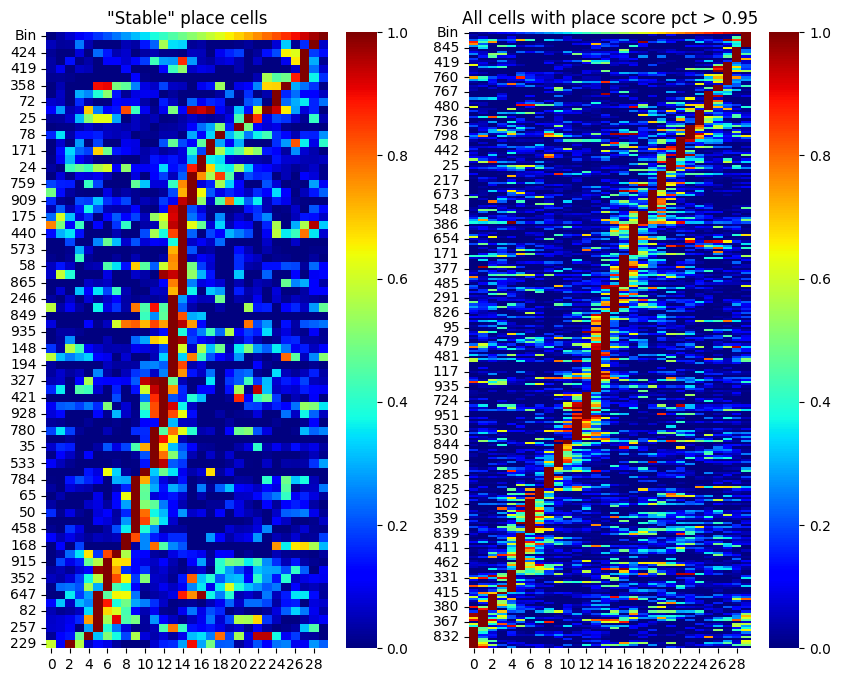

In [587]:
import seaborn as sns
# Let's sort them after the peaks of their mean activity.
stable_pcs_mean_signal = binned_signal[indices_high_reliability].reset_index()
pcs_mean_signal = binned_signal[indices_placecells].reset_index()

# Sort the DataFrame by the 'max_value' column
max_position_stable = stable_pcs_mean_signal.idxmax()
sorted_cells_stable = max_position_stable.sort_values(ascending=False).index
max_position = pcs_mean_signal.idxmax()
sorted_cells = max_position.sort_values(ascending=False).index

# Create a sorted DataFrame
stable_pcs_sorted = stable_pcs_mean_signal[sorted_cells_stable]
pcs_sorted = pcs_mean_signal[sorted_cells]

# normalize the mean signal
stable_pcs_sorted_normalized = stable_pcs_sorted.apply(lambda x: x / x.max(), axis=0)
pcs_sorted_normalized = pcs_sorted.apply(lambda x: x / x.max(), axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,8))
sns.heatmap(stable_pcs_sorted_normalized.T,ax=ax[0],cmap='jet')
ax[0].set_title('"Stable" place cells')
sns.heatmap(pcs_sorted_normalized.T,ax=ax[1],cmap='jet')
ax[1].set_title('All cells with place score pct > 0.95')

# Let's calculate the speed tuning of cells!

Similar as to how we did it with calculating place information, we bin the signal in speed bins. Then we use linear regression to see how well calcium activity of individual cells correlates with the animal's velocity. We use the  Benjamini/Hochberg correction to obtain a p-value.

However note the repetitive nature of the experiment! When the velocity is always high in the same place across laps, place cells might also be significantly velocity tuned. -> Interesting to check the overlap of speed and velocity tuned cells!



In [6]:
binwidth = 1 # cm/s
v_thresh = 2 # cm/s
Speed_Bin_edges = np.arange(v_thresh,max(velocity),binwidth) # boarders of position bins


# Include behavioural data in the dataframe to makes things comfortable:
calcium_signal_run.loc[:,'SpeedBin'] = np.digitize(calcium_signal_run.Velocity,Speed_Bin_edges)-1 # to make it start at0
calcium_signal_run = calcium_signal_run.reset_index(drop=True)

# loop through each cell to calculate binned signal
# bin signal using pandas 'pivot' function.
# Also count the datapoints per in and multiply with dt in order to obtain
# occupancy per bin

def speed_bin_signal(signal):

    speed_binned_signal = signal.groupby('SpeedBin').mean()[:cell_num]

    return speed_binned_signal


speed_binned_signal = speed_bin_signal(calcium_signal_run)

NameError: ignored

In [662]:
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests  # Import the multipletests function

def test_velocity_modulation(signal, velocity, alpha=0.05):
    X = velocity.reshape(-1, 1)
    X = sm.add_constant(X)
    y = signal

    model = sm.OLS(y, X).fit()

    p_value = model.pvalues[1]

    # Apply Benjamini-Hochberg correction to p-values
    corrected_p_values = multipletests([p_value], alpha=alpha, method='fdr_bh')

    return corrected_p_values[1][0]

corrected_p = np.zeros(cell_num)

for x in range(0,cell_num):
  corrected_p[x] = test_velocity_modulation(np.array(speed_binned_signal[x]),np.array(speed_binned_signal['Velocity']),0.05)
  # reshape because sklearn expects 2D array.

idx_speed_modulated_cells = np.where(corrected_p<0.01)[0]
print('indices of speed modulated cells:' + str(idx_speed_modulated_cells))

indices of speed modulated cells:[  2   3   6   7   8   9  10  14  17  23  24  25  31  34  35  36  40  45
  48  49  50  51  52  53  58  67  70  72  73  78  80  83  91  92  95  96
 100 102 105 108 110 114 115 116 117 120 123 129 130 135 138 139 145 155
 163 165 168 172 174 175 179 183 187 192 194 195 199 201 204 211 213 218
 220 232 235 236 239 240 243 246 247 248 251 257 262 264 266 273 276 280
 282 290 291 294 300 303 307 309 311 314 319 322 323 326 327 329 335 336
 339 341 345 346 353 369 370 371 373 375 378 386 388 390 391 397 398 402
 404 406 411 419 423 428 440 447 450 459 462 464 466 473 479 484 499 504
 507 509 525 526 528 532 533 537 538 540 541 543 551 557 567 568 571 573
 575 583 590 592 593 596 603 606 619 620 621 624 625 626 627 628 629 637
 642 645 646 651 652 659 661 666 669 670 671 672 673 677 678 682 683 684
 692 702 710 715 716 724 734 736 737 738 742 745 754 755 759 760 761 764
 779 780 782 792 794 799 801 807 808 811 812 814 815 816 818 820 823 826
 832 833 840 841 8

# Plot the overlap of speed and place tuned cells



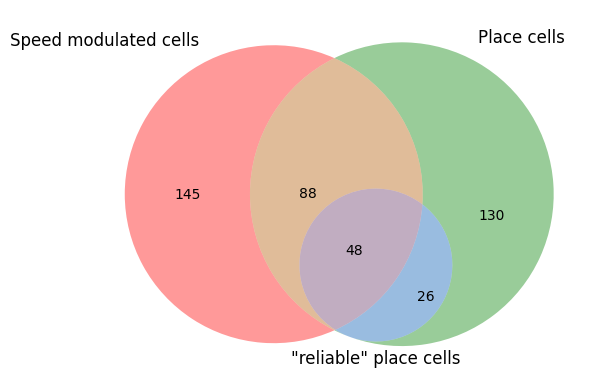

In [661]:
from matplotlib_venn import venn3

venn = venn3([set(idx_speed_modulated_cells), set(indices_placecells),set(indices_high_reliability)], ('Speed modulated cells', 'Place cells', '"reliable" place cells'))



